In [35]:
# Step 1: Import necessary packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from IPython.display import display

In [36]:
# Step 2: Load the dataset
cali_housing = fetch_california_housing(as_frame=True)
data = cali_housing.frame

# Get the description of the dataset
description = cali_housing.DESCR

print("Dataset Info:")
print(data.info())
print("\nDataset Description:")
display(data.describe())
print("\nFirst few rows of the dataset:")
display(data.head())
print("\nMetadata:")
print(description)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
None

Dataset Description:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010



First few rows of the dataset:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422



Metadata:
.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one

In [37]:
class DataProcessor:
    def __init__(self, data):
        self.data = data
        self.initial_features = data.columns.tolist()
        self.dropped_features = []

    def clean_outliers(self, columns):
        z_scores = np.abs(
            zscore(self.data[columns])
        )  # Compute z-scores for specified columns
        filtered_entries = (z_scores < 3).all(
            axis=1
        )  # Filter out rows with any z-score >= 3
        self.data = self.data[filtered_entries]  # Update the dataframe
        return self.data

    def create_corr_subset(self, exclude_features):
        subset = self.data.drop(
            columns=exclude_features
        )  # Create subset without specified features
        return subset

    def remove_highly_correlated_feature(
        self, target, threshold=0.9, exclude_features=None
    ):
        if exclude_features is None:
            exclude_features = []
        corr_matrix = self.data.corr().abs()  # Compute correlation matrix
        upper = corr_matrix.where(
            np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
        )  # Select upper triangle of correlation matrix
        to_drop = []  # List to track which features to drop
        target_corr = self.data.corr()[target].abs()  # Correlation with the target

        for column in upper.columns:
            if column in exclude_features:
                continue
            correlated_features = upper.index[upper[column] > threshold].tolist()
            if correlated_features:
                # Filter out features that are in the exclude list
                correlated_features = [
                    feat for feat in correlated_features if feat not in exclude_features
                ]
                if not correlated_features:
                    continue
                # Determine the feature with the lower correlation with the target
                to_remove = (
                    correlated_features[0]
                    if target_corr[correlated_features[0]] < target_corr[column]
                    else column
                )
                if to_remove not in to_drop:
                    to_drop.append(to_remove)

        # Drop the selected features
        self.dropped_features = to_drop
        self.data = self.data.drop(to_drop, axis=1)
        print(
            f"Dropped features due to high correlation (threshold={threshold}): {to_drop}"
        )
        return self.data

    def remove_manual_features(self, features):
        self.data = self.data.drop(columns=features)
        self.dropped_features.extend(features)
        print(f"Manually dropped features: {features}")
        return self.data

    def split_data(self, target, test_size=0.2, random_state=42):
        X = self.data.drop(columns=[target])  # Features
        y = self.data[target]  # Target variable
        return train_test_split(X, y, test_size=test_size, random_state=random_state)

In [38]:
# Step 4: Define Visualization class
class DataVisualizer:

    @staticmethod
    def visualize_correlations(df, title="Correlation Matrix"):
        corr_mtx = df.corr()
        mask_mtx = np.triu(np.ones_like(corr_mtx, dtype=bool))
        fig, ax = plt.subplots(figsize=(7, 6))
        sns.heatmap(df.corr(), annot=True, cmap="coolwarm", center=0, fmt=".2f", linewidths=0.5, square=True, ax=ax, mask=mask_mtx)
        plt.title(title)
        plt.show()

    @staticmethod
    def visualize_distributions(df, columns, x_limits=None):
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        for i, column in enumerate(columns):
            ax = axes[i // 2, i % 2]
            sns.histplot(df[column], ax=ax, kde=True, bins=50)
            ax.set_title(f"{column} Distribution")
            if x_limits and column in x_limits:
                ax.set_xlim(x_limits[column])  # Set x-axis limits if provided
            else:
                ax.set_xlim(
                    left=0
                )
        plt.tight_layout()
        plt.show()

In [39]:
# Step 5: Define ModelManager class
class ModelManager:
    def __init__(self, pipeline, param_grid=None):
        self.pipeline = pipeline
        self.param_grid = param_grid

    def train(self, X_train, y_train):
        if self.param_grid:
            grid_search = GridSearchCV(
                self.pipeline, self.param_grid, cv=5, scoring="r2", n_jobs=-1
            )
            grid_search.fit(X_train, y_train)
            self.pipeline = grid_search.best_estimator_
            self.best_params_ = grid_search.best_params_
        else:
            self.pipeline.fit(X_train, y_train)
        return self.pipeline

    def evaluate(self, X_test, y_test):
        y_pred = self.pipeline.predict(X_test)
        r2 = self.pipeline.score(X_test, y_test)
        mae = mean_absolute_error(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        return r2, mae, mape

    def get_best_params(self):
        if self.param_grid:
            return self.best_params_
        return None

In [40]:
# Step 6: Define ResultDisplay class
class ResultDisplay:
    @staticmethod
    def display_metrics(r2, mae, mape):
        metrics_df = pd.DataFrame({
            'R2': [r2],
            'MAE': [mae],
            'MAPE': [mape]
        })
        display(metrics_df)

    @staticmethod
    def compare_metrics(previous_metrics, new_metrics):
        comparison_df = pd.DataFrame({
            'Metric': ['R2', 'MAE', 'MAPE'],
            'Previous': previous_metrics,
            'New': new_metrics
        })
        display(comparison_df)
        
        if (new_metrics[0] > previous_metrics[0]) and (new_metrics[1] < previous_metrics[1]) and (new_metrics[2] < previous_metrics[2]):
            print("The new model has improved performance.")
        else:
            print("The new model did not improve performance.")

In [41]:
# Define features
features = ["AveRooms", "AveBedrms", "AveOccup", "Population"]

# Define x-axis limits for specific features
x_limits = {
    "AveRooms": (0, 20),
    "AveBedrms": (0, 6),
    "AveOccup": (0, 50),
    "Population": (0, 5000),
}

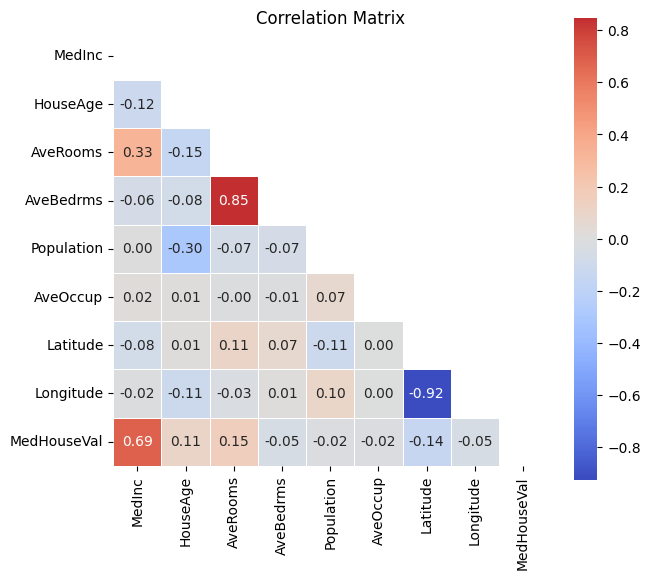

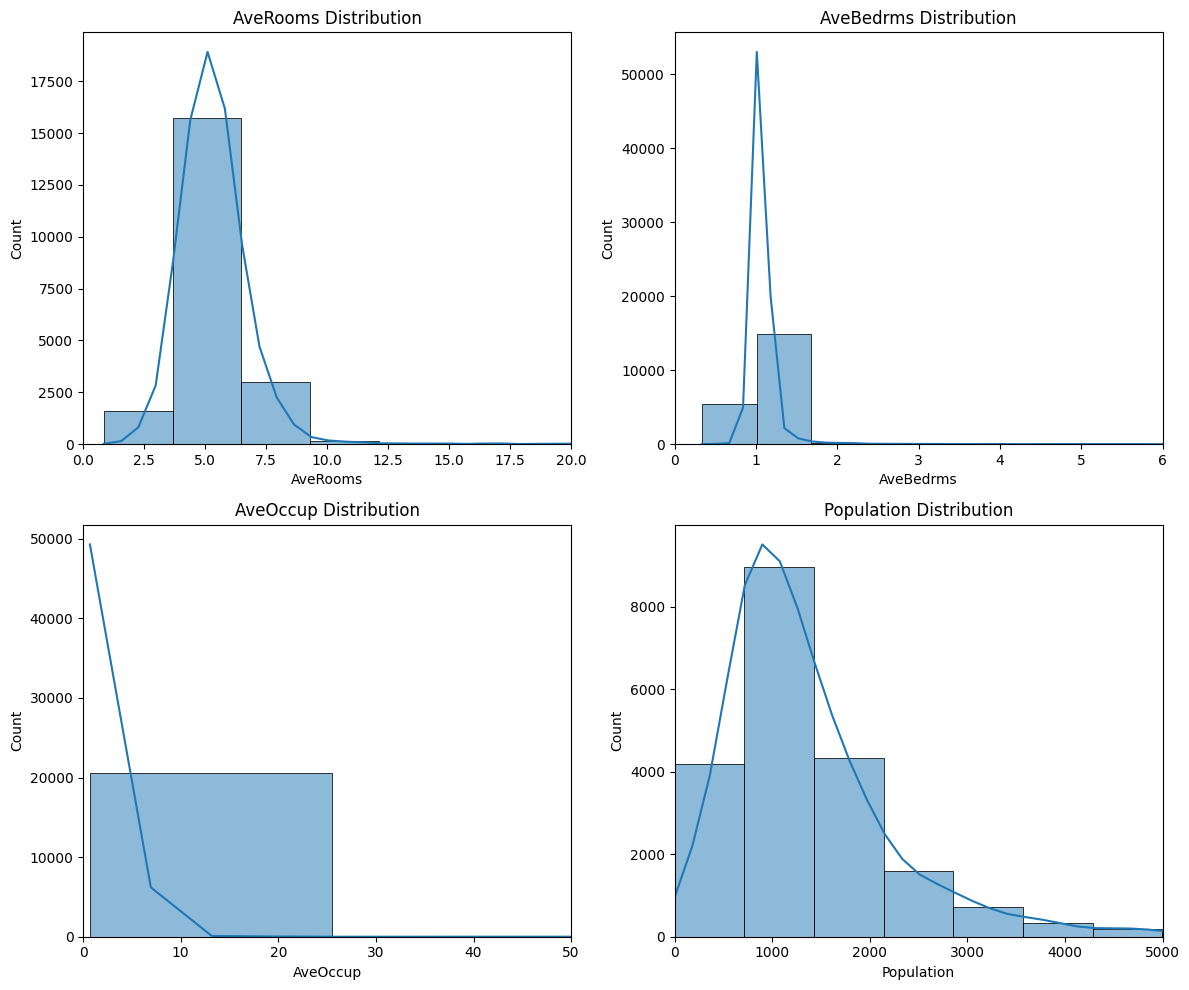

In [42]:
# Step 7: Visualize raw data
DataVisualizer.visualize_correlations(data)
DataVisualizer.visualize_distributions(data, features, x_limits)

In [43]:
# Step 8: Instantiate DataProcessor and Process the data
processor = DataProcessor(data)
data_clean = processor.clean_outliers(features)

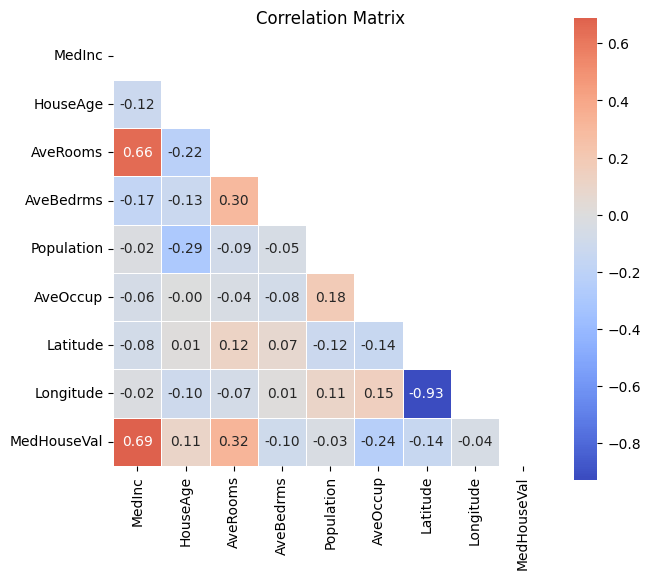

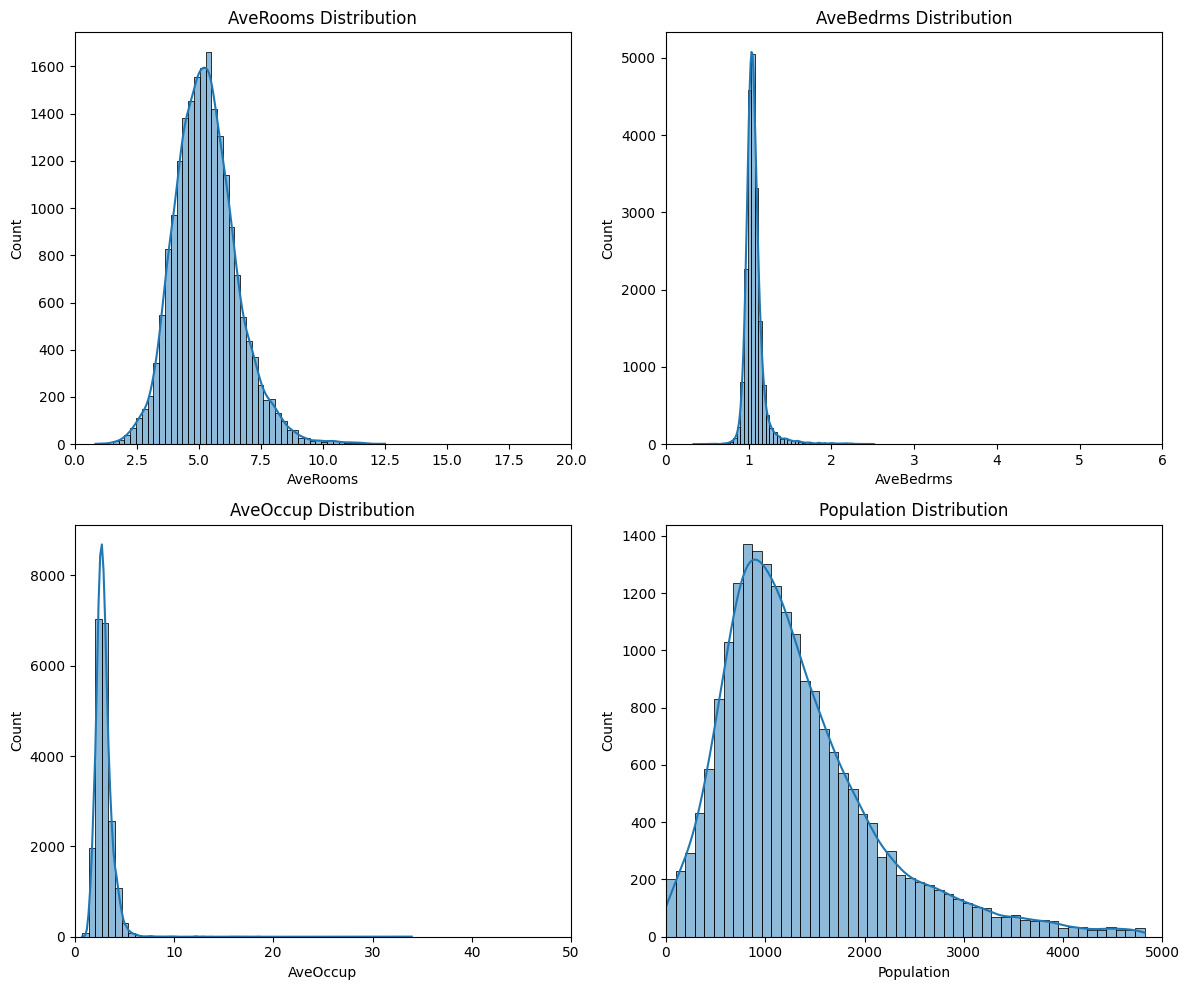

In [44]:
# Step 9: Display and visualize data
DataVisualizer.visualize_correlations(data_clean)
DataVisualizer.visualize_distributions(data_clean, features, x_limits)

In [45]:
# Create subset without longitude and latitude
subset = processor.create_corr_subset(["Longitude", "Latitude"])

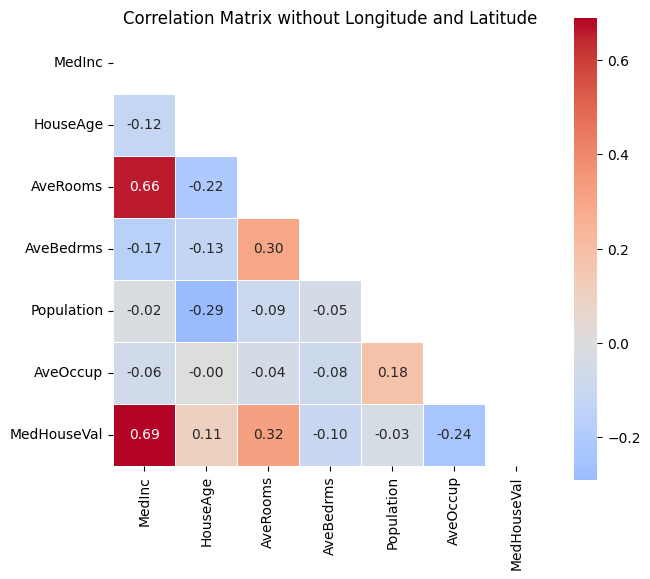

In [46]:
# Visualize the correlation matrix without Longitude and Latitude using DataVisualizer
DataVisualizer.visualize_correlations(
    subset, title="Correlation Matrix without Longitude and Latitude"
)

In [47]:
# Step 10: # Remove highly correlated features, excluding longitude and latitude
data_clean = processor.remove_highly_correlated_feature(
    target="MedHouseVal", threshold=0.8, exclude_features=["Longitude", "Latitude"]
)

Dropped features due to high correlation (threshold=0.8): []


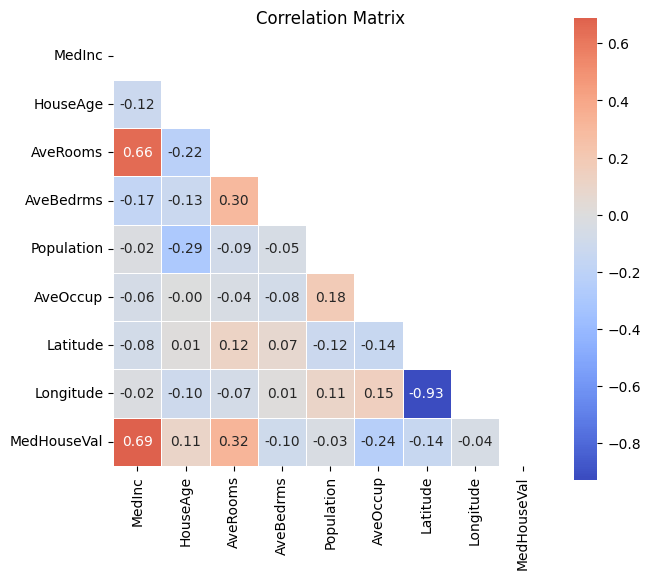

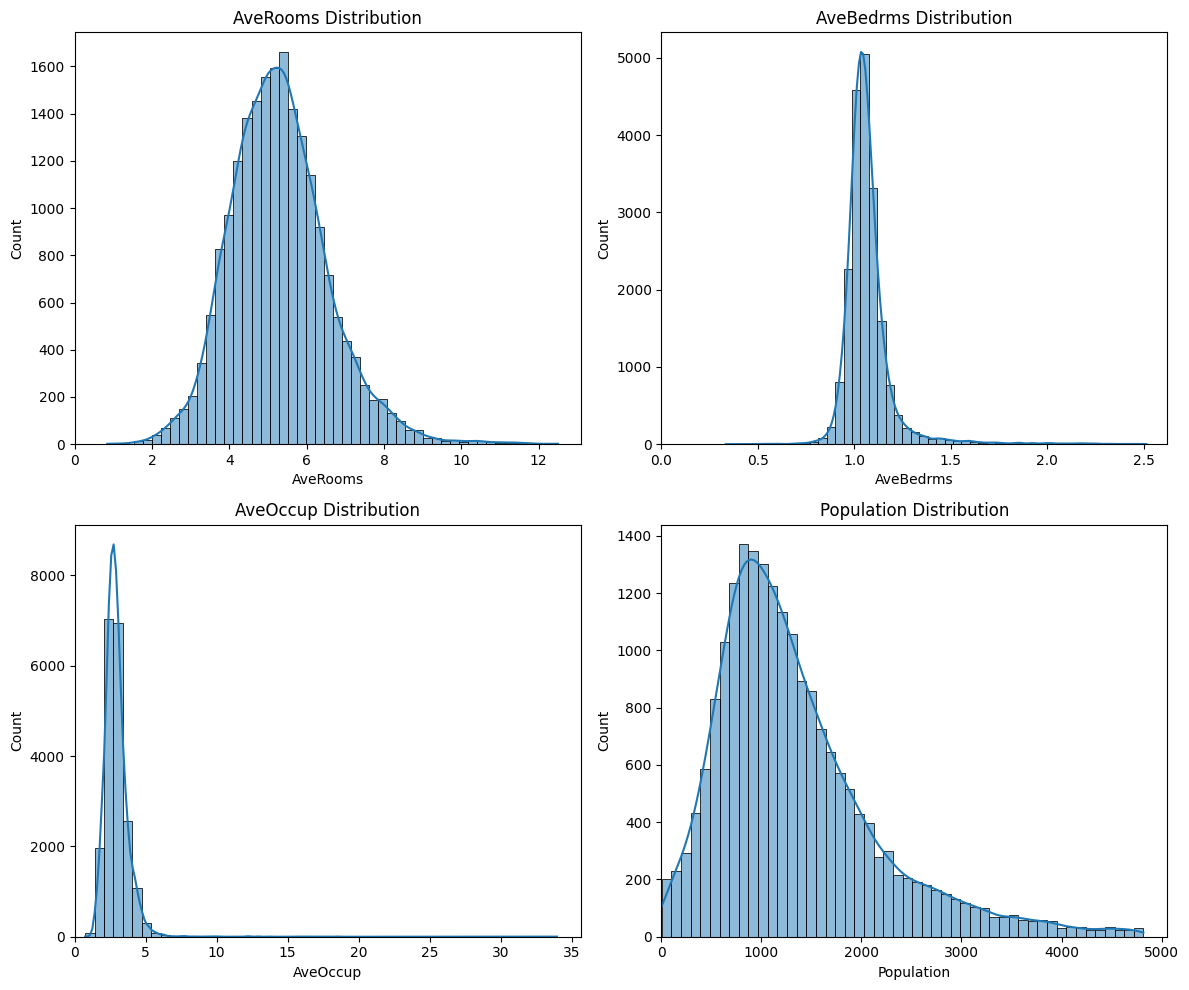

In [48]:
# Step 11: Display and visualize data after removing highly correlated features
DataVisualizer.visualize_correlations(data_clean)
DataVisualizer.visualize_distributions(data_clean, features)

In [49]:
# Step 12: Split the data
X_train, X_test, y_train, y_test = processor.split_data(target="MedHouseVal")

In [50]:
# Step 13: Define pipelines for different models, including Polynomial Regression
pipelines = {
    "LinearRegression": Pipeline(
        [("scaler", StandardScaler()), ("regressor", LinearRegression())]
    ),
    "PolynomialRegression": Pipeline(
        [
            ("poly_features", PolynomialFeatures()),
            ("scaler", StandardScaler()),
            ("regressor", LinearRegression()),
        ]
    ),
}

In [51]:
# Step 14: Define hyperparameters for different models
param_grids = {
    "LinearRegression": {"regressor__fit_intercept": [True, False]},
    "PolynomialRegression": {
        "poly_features__degree": [2, 3, 4],
        "regressor__fit_intercept": [True, False],
    },
}

In [52]:
# Step 15: Train and evaluate different models
results = {}
for model_name, pipeline in pipelines.items():
    param_grid = param_grids[model_name]
    manager = ModelManager(pipeline, param_grid)
    trained_pipeline = manager.train(X_train, y_train)
    r2, mae, mape = manager.evaluate(X_test, y_test)
    best_params = manager.get_best_params()
    results[model_name] = {
        "R2": r2,
        "MAE": mae,
        "MAPE": mape,
        "Best Params": best_params,
    }

In [53]:
# Display results for different models
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    ResultDisplay.display_metrics(metrics["R2"], metrics["MAE"], metrics["MAPE"])
    print(f"Best Parameters: {metrics['Best Params']}")
    print("\n")

Model: LinearRegression


,R2,MAE,MAPE
0,0.659452,0.499281,0.290982


Best Parameters: {'regressor__fit_intercept': True}


Model: PolynomialRegression


,R2,MAE,MAPE
0,0.715972,0.443771,0.250055


Best Parameters: {'poly_features__degree': 2, 'regressor__fit_intercept': True}




In [54]:
# Step 16: Compare new metrics with previous model metrics and make conclusions
# Old metrics for Linear Regression
previous_lr_r2, previous_lr_mae, previous_lr_mape = 0.61, 0.52, 0.31
# Old metrics for Polynomial Regression
previous_pr_r2, previous_pr_mae, previous_pr_mape = 0.69, 0.46, 0.27

comparison_results = []

# Assuming 'results' is a dictionary with model names as keys and their metrics as values
for model_name, metrics in results.items():
    if model_name == "LinearRegression":
        prev_r2, prev_mae, prev_mape = previous_lr_r2, previous_lr_mae, previous_lr_mape
    elif model_name == "PolynomialRegression":
        prev_r2, prev_mae, prev_mape = previous_pr_r2, previous_pr_mae, previous_pr_mape
    else:
        # Default values in case of other models, you can adjust these as needed
        prev_r2, prev_mae, prev_mape = 0, 0, 0

    print(f"Comparison for model: {model_name}")
    ResultDisplay.compare_metrics(
        [prev_r2, prev_mae, prev_mape],
        [metrics["R2"], metrics["MAE"], metrics["MAPE"]],
    )
    comparison_results.append(
        (model_name, metrics["R2"], metrics["MAE"], metrics["MAPE"])
    )
    print("\n")

# Displaying the comparison results in a table
comparison_df = pd.DataFrame(comparison_results, columns=["Model", "R2", "MAE", "MAPE"])
display(comparison_df)

Comparison for model: LinearRegression


,Metric,Previous,New
0,R2,0.61,0.659452
1,MAE,0.52,0.499281
2,MAPE,0.31,0.290982


The new model has improved performance.


Comparison for model: PolynomialRegression


,Metric,Previous,New
0,R2,0.69,0.715972
1,MAE,0.46,0.443771
2,MAPE,0.27,0.250055


The new model has improved performance.




,Model,R2,MAE,MAPE
0,LinearRegression,0.659452,0.499281,0.290982
1,PolynomialRegression,0.715972,0.443771,0.250055
